In [1]:
path_15_original = "../eval_outputs/triviaqa_Qwen2.5-1.5B-Instruct_validation_None_threshold.tsv"
path_15_trained = "../eval_outputs/triviaqa_qwen1.5-ml3-iter1000_iter750_validation_None_threshold.tsv"

path_3_original = "../eval_outputs/triviaqa_Qwen2.5-3B-Instruct_validation_None_threshold.tsv"
path_3_trained = "../eval_outputs/triviaqa_qwen3-ml3-iter1000_iter750_validation_None_threshold.tsv"

path_7_original = "../eval_outputs/triviaqa_Qwen2.5-7B-Instruct_validation_None_threshold.tsv"
path_7_trained = "../eval_outputs/triviaqa_qwen7-ml3-iter1000_iter750_validation_None_threshold.tsv"

In [5]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager
import pandas as pd

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['text.color'] = '#333333'
plt.rcParams['axes.labelcolor'] = '#333333'
plt.rcParams['xtick.color'] = '#333333'
plt.rcParams['ytick.color'] = '#333333'

font_manager.fontManager.addfont('fonts/Helvetica.ttc')
font_manager.fontManager.addfont('fonts/HelveticaNeue.ttc')
font_manager.fontManager.addfont('fonts/Arial.ttf')
font_manager.fontManager.addfont('fonts/Arial Bold.ttf')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = [
    # 'Helvetica',
    'Arial',
    'DejaVu Sans',
    'HelveticaNeue',
    'Helvetica Neue',
]
font_path = font_manager.findfont(font_manager.FontProperties(family=['sans-serif']))
print(f"Actual font file being used: {font_path}")

# df = pd.read_csv(path_15_trained, sep="\t")
# df.head()
# correctness = df["direct_correctness"]
# confidence = df["confidence"]

model_info = [
    ("1.5B", path_15_original, path_15_trained),
    ("3B", path_3_original, path_3_trained),
    ("7B", path_7_original, path_7_trained),
]

Actual font file being used: /scratch/cluster/sangjun/work/meta-cognition/notebooks/fonts/Arial.ttf


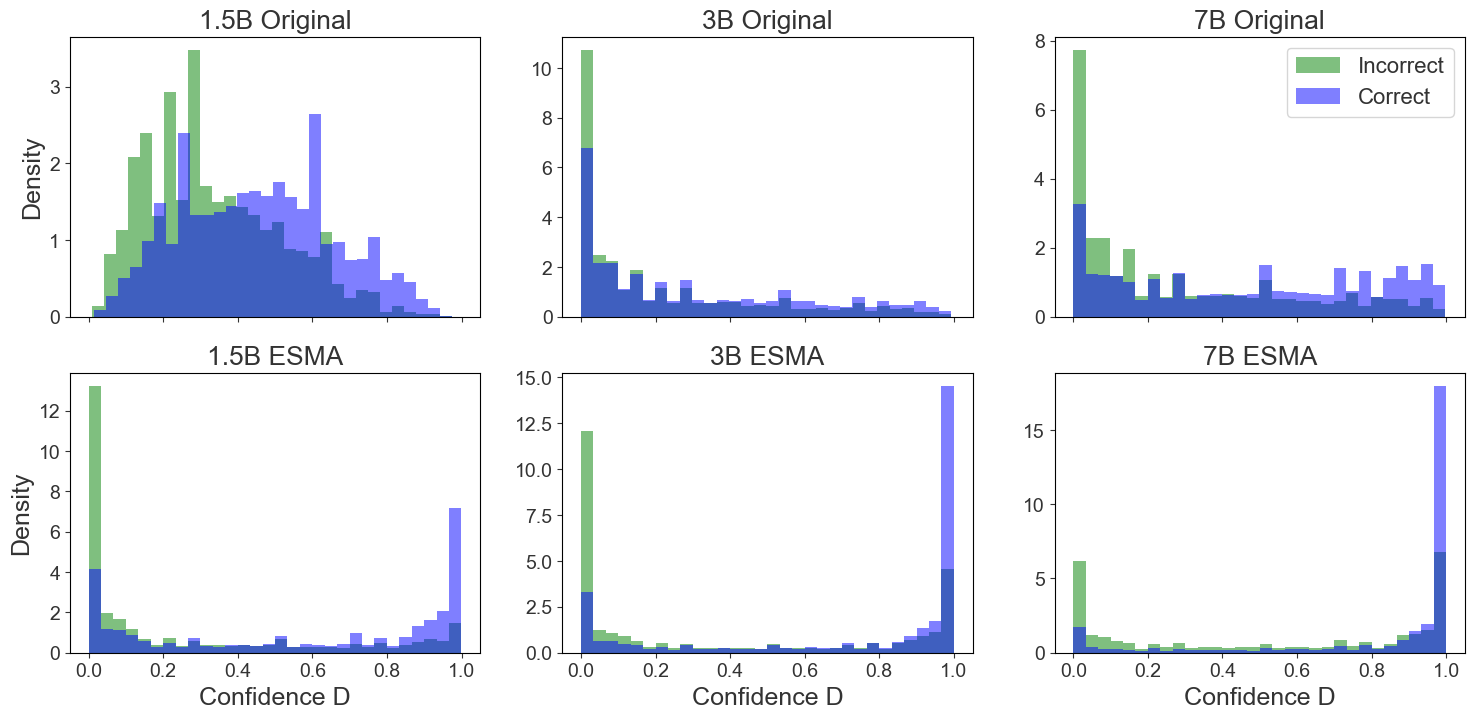

In [ ]:

# To plot 6 subplots in 2x3 layout (transposed):
# Row 1: Base (1.5B, 3B, 7B)
# Row 2: Fine-tuned (1.5B, 3B, 7B)

fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharex=True)

for row, (version, _) in enumerate([('Original', None), ('ESMA', None)]):
    for col, (model_name, original_path, trained_path) in enumerate(model_info):
        path = original_path if version != 'ESMA' else trained_path
        df_tmp = pd.read_csv(path, sep="\t")
        correctness = df_tmp["direct_correctness"]
        confidence = df_tmp["confidence"]
        correct_conf = confidence[correctness == 1]
        incorrect_conf = confidence[correctness == 0]

        ax = axes[row, col]
        ax.hist(
            incorrect_conf,
            bins=30,
            alpha=0.5,
            label='Incorrect',
            color='green',
            density=True,
            histtype='bar',
        )
        ax.hist(
            correct_conf,
            bins=30,
            alpha=0.5,
            label='Correct',
            color='blue',
            density=True,
            histtype='bar',
        )
        if col == 0:
            ax.set_ylabel(f"Density", fontsize=18)
        if row == 1:
            ax.set_xlabel('Confidence D', fontsize=18)
        ax.set_title(f"{model_name} {version}".strip(), fontsize=19)
        ax.tick_params(axis='both', which='major', labelsize=14)
        if row == 0 and col == 2:
            legend = ax.legend(loc='upper right', fontsize=16)
        else:
            # Don't show legend except for the specified plot
            ax.legend([],[], frameon=False)

# plt.suptitle('Confidence Distribution by Correctness', fontsize=22, y=0.93)
# plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('figures/confidence-distribution.pdf', dpi=300, transparent=True, bbox_inches='tight', format='pdf')
plt.show()


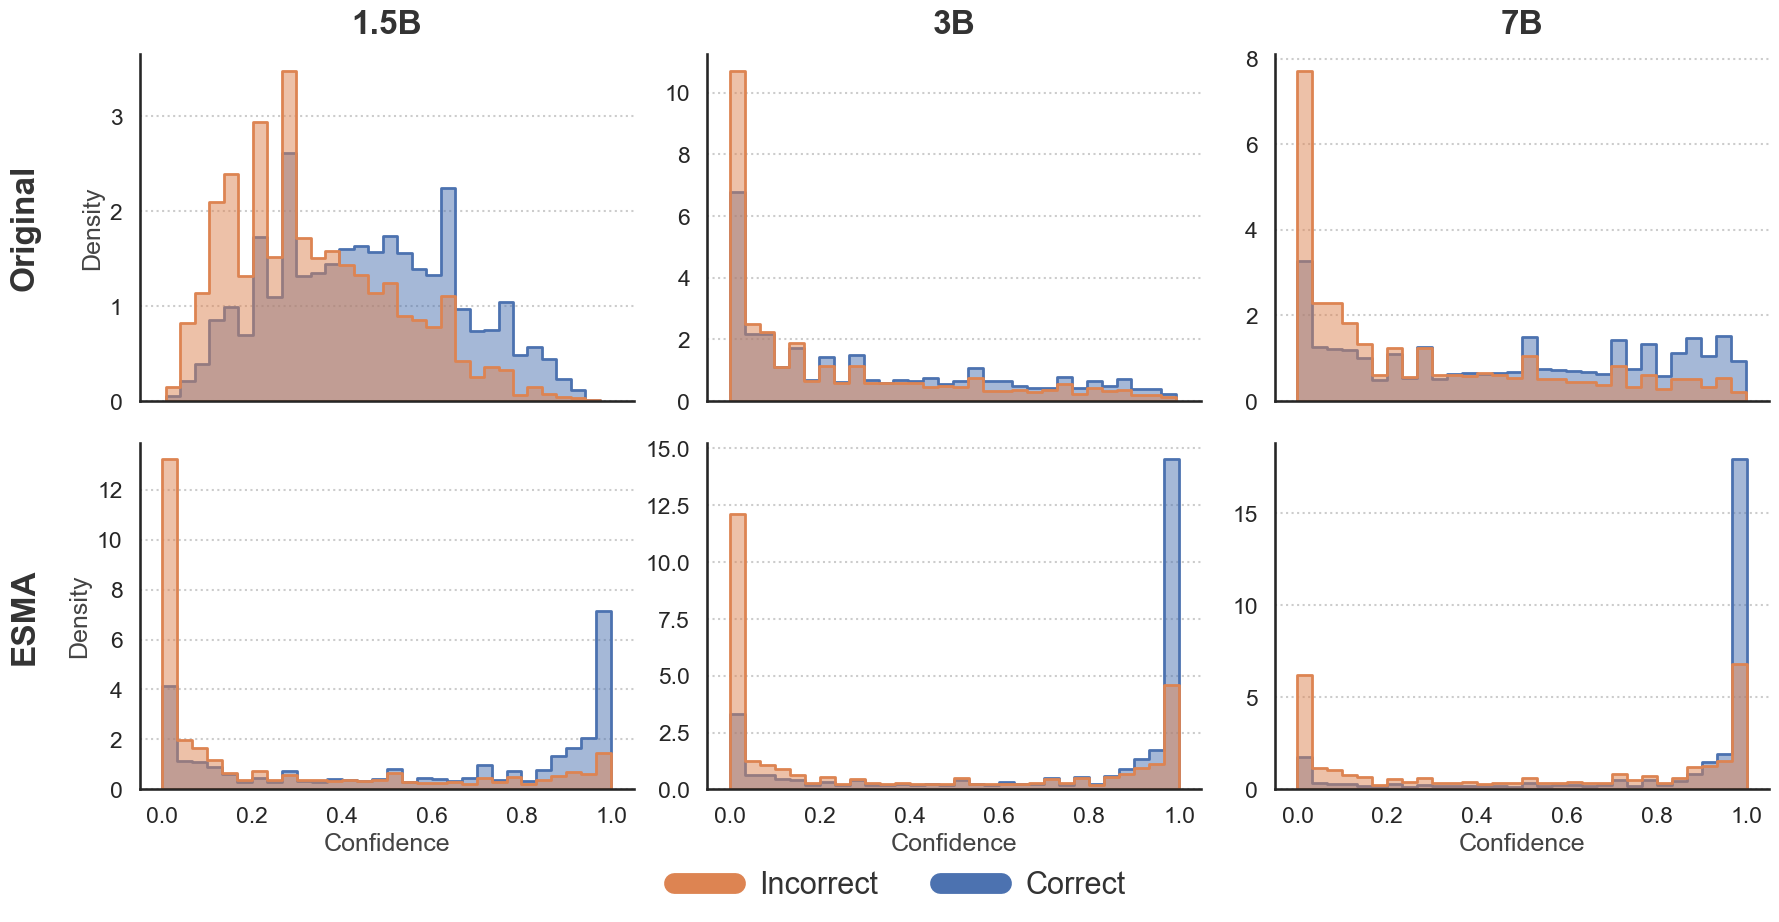

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# --- 1. 설정 및 스타일 ---
sns.set_theme(style="white", context="talk")
plt.rcParams['font.family'] = 'sans-serif'

# 더 진하고 선명한 색상 (Matplotlib Default Strong Colors)
# 파랑(Correct), 빨강(Incorrect)
PALETTE = {"Correct": "#4C72B0", "Incorrect": "#DD8452"}

# --- 2. 데이터 준비 (이전과 동일) ---
data_frames = []
for col_idx, (model_name, path_original, path_trained) in enumerate(model_info):
    for version_name, path in [("Original", path_original), ("ESMA", path_trained)]:
        df_tmp = pd.read_csv(path, sep="\t")
        df_tmp["Outcome"] = df_tmp["direct_correctness"].map({1: "Correct", 0: "Incorrect"})
        df_tmp["Model"] = model_name
        df_tmp["Version"] = version_name
        data_frames.append(df_tmp[["confidence", "Outcome", "Model", "Version"]])

combined_df = pd.concat(data_frames, ignore_index=True)

# --- 3. 플로팅 ---
# sharey='row': 같은 행끼리만 Y축 공유 (Base는 Base끼리, ESMA는 ESMA끼리 비교)
fig, axes = plt.subplots(2, 3, figsize=(18, 9), sharex=True)

rows = ["Original", "ESMA"]
cols = ["1.5B", "3B", "7B"]

for i, row_val in enumerate(rows):
    for j, col_val in enumerate(cols):
        ax = axes[i, j]

        subset = combined_df[
            (combined_df["Version"] == row_val) &
            (combined_df["Model"] == col_val)
        ]

        sns.histplot(
            data=subset,
            x="confidence",
            hue="Outcome",
            hue_order=["Incorrect", "Correct"],
            palette=PALETTE,
            bins=30,
            stat="density",
            element="step",
            fill=True,
            alpha=0.5,           # 투명도를 낮춰서(색을 진하게) 내부를 채움
            linewidth=2,         # 테두리 선을 굵게
            common_norm=False,
            legend=False,
            ax=ax
        )

        # --- 디자인 다듬기 ---

        # Row Label (왼쪽 Y축)
        if j == 0:
            ax.set_ylabel("Density", fontweight='normal', color='#444444')
            # 행 이름(Base/ESMA)을 그래프 왼쪽 밖에 크게 표시
            ax.text(-0.2, 0.5, row_val, transform=ax.transAxes,
                    fontsize=24, fontweight='bold', va='center', ha='right', rotation=90, color='#333333')
        else:
            ax.set_ylabel("")

        # Column Title (맨 윗줄만)
        if i == 0:
            ax.set_title(f"{col_val}", fontsize=24, fontweight='bold', pad=15, color='#333333')

        # X축 라벨 (맨 아랫줄만)
        if i == 1:
            ax.set_xlabel("Confidence", fontweight='normal', color='#444444')

        # 테두리 정리
        sns.despine(ax=ax)

        # 그리드 추가 (그래프가 붕 떠보이지 않게 잡아주는 역할)
        ax.grid(axis='y', linestyle=':', alpha=0.4, color='gray')

# --- 4. 범례 및 마무리 ---

legend_elements = [
    Line2D([0], [0], color=PALETTE["Incorrect"], lw=15, label='Incorrect'),
    Line2D([0], [0], color=PALETTE["Correct"], lw=15, label='Correct'),
    # Patch(facecolor=PALETTE["Correct"], label='Correct'),
    # Patch(facecolor=PALETTE["Incorrect"], label='Incorrect')
]

fig.legend(
    handles=legend_elements,
    loc='lower center',
    bbox_to_anchor=(0.5, -.05), # 그래프 위쪽 중앙
    ncol=2,
    frameon=False,
    fontsize=22,
    labelcolor='#333333'
)

plt.tight_layout()
plt.savefig('figures/confidence-distribution.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

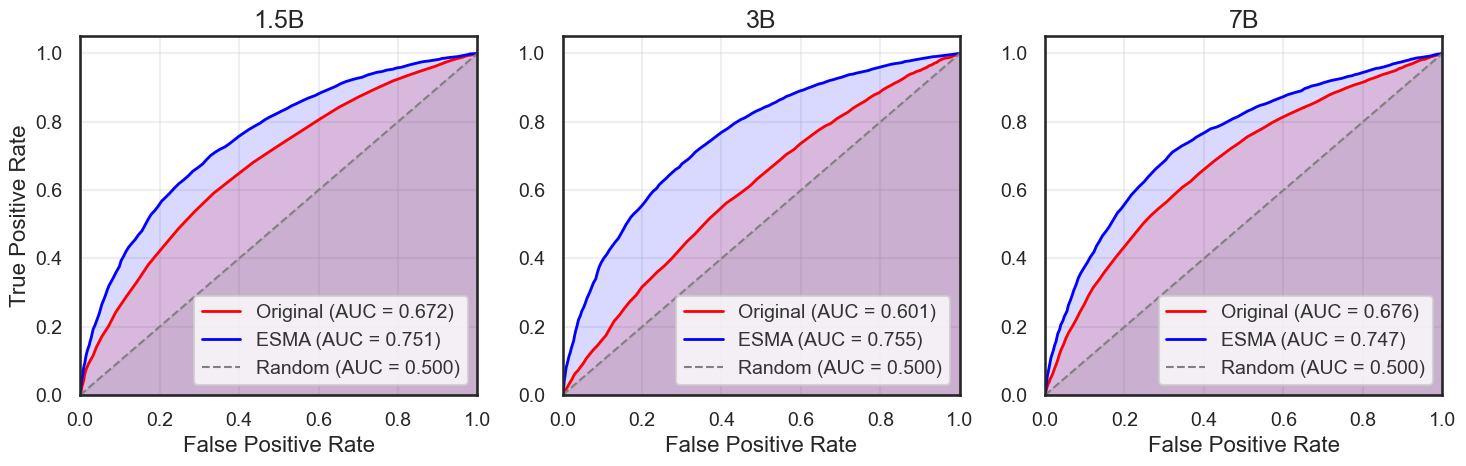

In [ ]:
from sklearn.metrics import roc_curve, auc

# To plot 3 subplots horizontally for Type 2 AUC ROC curves:
# Each subplot shows both original and trained models overlaid

model_info = [
    ("1.5B", path_15_original, path_15_trained),
    ("3B", path_3_original, path_3_trained),
    ("7B", path_7_original, path_7_trained),
]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for col, (model_name, original_path, trained_path) in enumerate(model_info):
    ax = axes[col]

    # Plot original model
    df_original = pd.read_csv(original_path, sep="\t")
    correctness_orig = df_original["direct_correctness"]
    confidence_orig = df_original["confidence"]
    fpr_orig, tpr_orig, _ = roc_curve(correctness_orig, confidence_orig)
    roc_auc_orig = auc(fpr_orig, tpr_orig)
    ax.plot(fpr_orig, tpr_orig, color='red', lw=2, label=f'Original (AUC = {roc_auc_orig:.3f})')
    ax.fill_between(fpr_orig, tpr_orig, color='red', alpha=0.15)

    # Plot trained model
    df_trained = pd.read_csv(trained_path, sep="\t")
    correctness_train = df_trained["direct_correctness"]
    confidence_train = df_trained["confidence"]
    fpr_train, tpr_train, _ = roc_curve(correctness_train, confidence_train)
    roc_auc_train = auc(fpr_train, tpr_train)
    ax.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'ESMA (AUC = {roc_auc_train:.3f})')
    ax.fill_between(fpr_train, tpr_train, color='blue', alpha=0.15)

    # Plot diagonal reference line
    ax.plot([0, 1], [0, 1], color='gray', lw=1.5, linestyle='--', label='Random (AUC = 0.500)')
    ax.fill_between([0, 1], [0, 1], color='gray', alpha=0.15)

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=16)
    if col == 0:
        ax.set_ylabel('True Positive Rate', fontsize=16)
    ax.set_title(f"{model_name}", fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='lower right', fontsize=14)

# plt.suptitle('Type 2 AUC ROC Curves', fontsize=20, y=1.02)
plt.tight_layout()
plt.savefig('figures/type2-auc-roc.pdf', dpi=300, transparent=True, bbox_inches='tight', format='pdf')
plt.show()


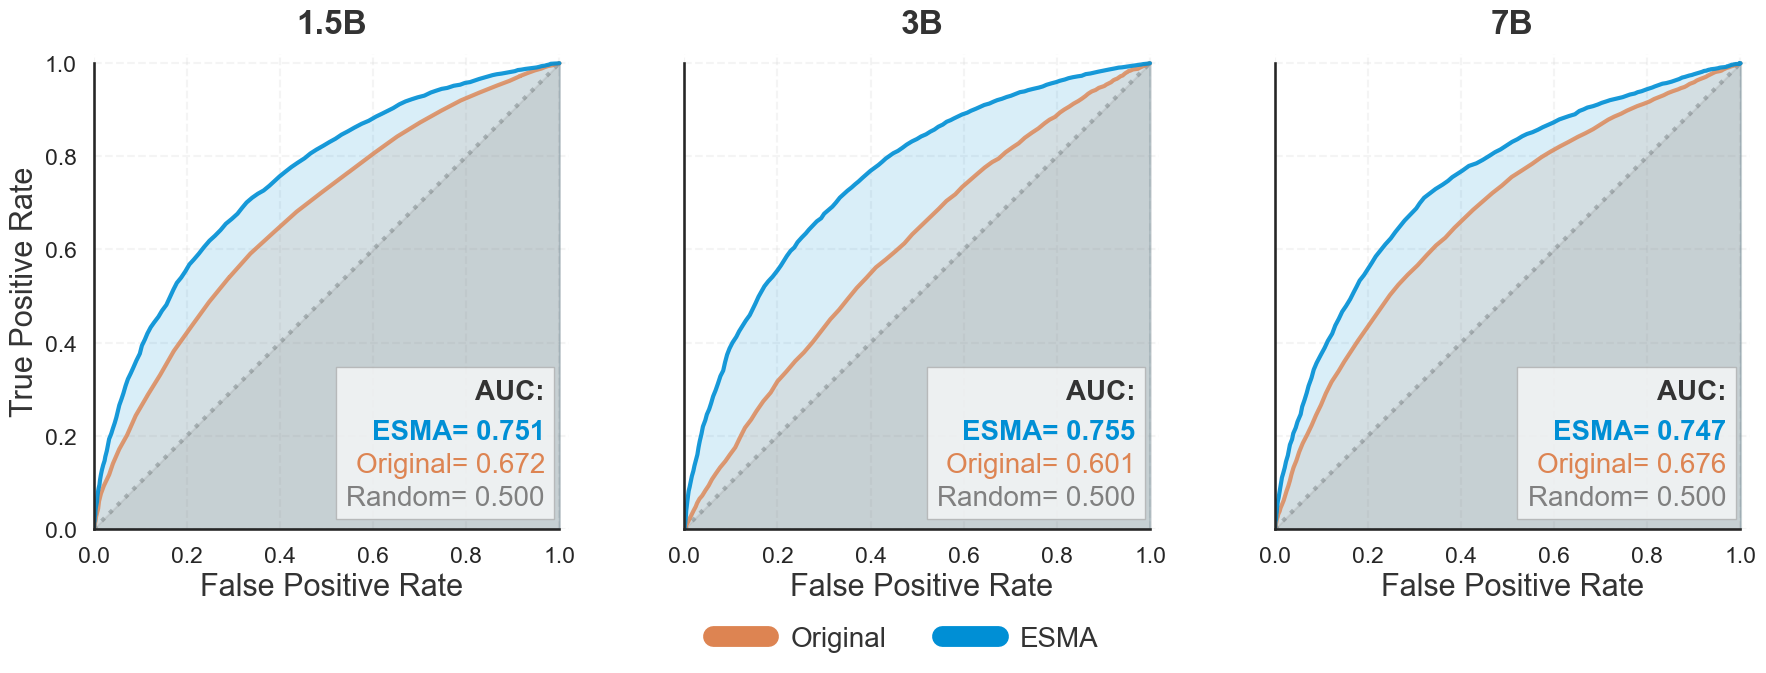

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_curve, auc
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
import numpy as np

# --- 1. 스타일 및 컬러 설정 ---
sns.set_theme(style="white", context="talk")
plt.rcParams['font.family'] = 'sans-serif'

# 이전과 동일한 컬러 팔레트 (일관성 유지)
# ESMA (Trained) -> Blue (긍정/개선)
# Original (Base) -> Orange (기준/대조)
COLORS = {
    "Base": "#DD8452",  # Muted Orange
    "ESMA": "#008FD5"   # Muted Blue
}

# --- 2. 데이터 및 플로팅 ---
model_info = [
    ("1.5B", path_15_original, path_15_trained),
    ("3B", path_3_original, path_3_trained),
    ("7B", path_7_original, path_7_trained),
]

# 1x3 레이아웃, 크기 조정
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

for col, (model_name, original_path, trained_path) in enumerate(model_info):
    ax = axes[col]

    # --- 2-1. Base (Original) ---
    df_orig = pd.read_csv(original_path, sep="\t")
    fpr_orig, tpr_orig, _ = roc_curve(df_orig["direct_correctness"], df_orig["confidence"])
    auc_orig = auc(fpr_orig, tpr_orig)

    ax.plot(fpr_orig, tpr_orig,
            color=COLORS["Base"], lw=3, alpha=0.8,
            label='Base')
    ax.fill_between(fpr_orig, tpr_orig, color=COLORS["Base"], alpha=0.15)

    # --- 2-2. ESMA (Trained) ---
    df_train = pd.read_csv(trained_path, sep="\t")
    fpr_train, tpr_train, _ = roc_curve(df_train["direct_correctness"], df_train["confidence"])
    auc_train = auc(fpr_train, tpr_train)

    ax.plot(fpr_train, tpr_train,
            color=COLORS["ESMA"], lw=3, alpha=0.9,
            label='ESMA')
    ax.fill_between(fpr_train, tpr_train, color=COLORS["ESMA"], alpha=0.15)
    # --- 2-3. 디자인 요소 (Diagonal & Text) ---

    # 대각선 (Random Guess) - 뒤로 숨기기 (zorder 낮춤)
    ax.plot([0, 1], [0, 1], color='gray', lw=3, linestyle=':', alpha=0.5, zorder=0)
    ax.fill_between([0, 1], [0, 1], color='gray', alpha=0.15)

    # (1) 배경 박스 좌표 설정 (ax.transAxes 기준: 0~1 사이 값)
    # x: 0.55 ~ 0.98 (오른쪽 하단 영역 차지)
    # y: 0.02 ~ 0.32 (텍스트 높이에 맞춰 설정)
    rect_x, rect_y = 0.51, 0.02
    rect_width, rect_height = 0.46, 0.32

    # (2) 사각형 그리기
    rect = Rectangle(
        (rect_x, rect_y), rect_width, rect_height,
        transform=ax.transAxes,  # 데이터 좌표가 아닌 축(0~1) 좌표 사용
        facecolor='white',       # 흰색 배경
        alpha=0.7,               # 투명도 (그래프가 살짝 비치게)
        edgecolor='darkgray',        # 테두리 없음
        zorder=4,                 # 그래프(Line)보다 위에, 텍스트보다는 아래에 오도록 설정
        linewidth=1,
    )
    ax.add_patch(rect)

    # AUC 점수를 그래프 내부에 텍스트로 표시 (범례 대신)
    # 위치: 오른쪽 하단 (0.95, 0.05) 기준
    ax.text(0.95, 0.26, "AUC:", transform=ax.transAxes, ha='right', va='bottom', fontsize=20, fontweight='bold', color='#333333', zorder=5)
    ax.text(0.95, 0.19, f"ESMA= {auc_train:.3f}",
            transform=ax.transAxes, ha='right', fontsize=20, fontweight='bold', color=COLORS["ESMA"], zorder=5)
    ax.text(0.95, 0.12, f"Original= {auc_orig:.3f}",
            transform=ax.transAxes, ha='right', fontsize=20, fontweight='normal', color=COLORS["Base"], zorder=5)
    ax.text(0.95, 0.05, "Random= 0.500",
            transform=ax.transAxes, ha='right', fontsize=20, fontweight='normal', color='gray', zorder=5)

    # 축 설정
    ax.set_xlim([0.0, 1.02])
    ax.set_ylim([0.0, 1.02])

    ax.set_xticks(np.arange(0, 1.1, 0.2))
    ax.set_yticks(np.arange(0, 1.1, 0.2)) # Y축도 확실하게 0.2 단위로 고정

    ax.set_aspect('equal') # 정사각형 비율 유지 (ROC 해석에 중요)

    # 타이틀 및 라벨
    ax.set_title(f"{model_name}", fontsize=24, fontweight='bold', pad=15, color='#333333')
    ax.set_xlabel('False Positive Rate', fontsize=22, color='#333333')

    if col == 0:
        ax.set_ylabel('True Positive Rate', fontsize=22, color='#333333')
    else:
        ax.set_ylabel('') # 첫 번째 그래프만 Y축 라벨 표시
        ax.tick_params(labelleft=False) # 나머지는 숫자 숨김 (선택사항)

    # 깔끔한 테두리 정리
    sns.despine(ax=ax, trim=True)
    ax.grid(True, linestyle='--', alpha=0.2)

# --- 3. 공통 범례 (하단) ---
legend_elements = [
    Line2D([0], [0], color=COLORS["Base"], lw=15, label='Original'),
    Line2D([0], [0], color=COLORS["ESMA"], lw=15, label='ESMA')
]

fig.legend(
    handles=legend_elements,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.12), # 그래프 아래쪽
    ncol=2,
    frameon=False,
    fontsize=20,
    labelcolor='#333333'
)

# 파일 저장
plt.savefig('figures/type2-auc-roc.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()